# Implement Linear Regression with Numpy

This project is aimed to review some key point in linear regression. In order to show a completely raw, basic and primitive understanding, **no morden machine learning modules** (sklearn, pytorch) will be used. 

### Initialization
To start with, some modules are necessary to be loaded:
- `numpy` for matrix calculation
- `pandas` for data reading
- `matplotlib` for data visualization

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


### Step by Step
The whole process can be decomposed to the followin steps:
1. Load the data
2. analyse data, and deside which to predict
3. devide raw data into three part: train_set, dev_set, test_set.
    - both of them should set X and Y apart
4. build a linear regression model
5. train the model with test_set
    - graph the behaviour of cost function v.s. #\iteration
6. use dev_set to tune the hyperparameter `learning rate`
    - graph the behavious of cost function v.s. #\iteration
    - list out the accuracy of each learning rate
7. test the final result by test_set
    - graph the behavious of cost function v.s. #\iteration
    - list out the accuracy of each learning rate
8. list a big chart to compare test accuracy, dev accuracy, test accuracy
    - overfitting? (high variance)
    - underfitting? (high biaes)

Notice that I will use $R^{2}$ to evaluate the accuracy. More info will be introduced later. 


In [2]:
# load data
df = pd.read_csv("Boston.csv", index_col=0) # set first column as index. also can be directly droped
print(df.head()) # Overview of raw data
print(df.shape) # Number of features(n) & Number of examples(m)
print(df.columns) # What are the features? 

      crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
1  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
2  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
3  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
4  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
5  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

    black  lstat  medv  
1  396.90   4.98  24.0  
2  396.90   9.14  21.6  
3  392.83   4.03  34.7  
4  394.63   2.94  33.4  
5  396.90   5.33  36.2  
(506, 14)
Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'black', 'lstat', 'medv'],
      dtype='object')


### Data analysis
Raw data consists of 14 features with 506 examples. Thats quite a few data size, so no wonder it may perform badly. 
The 14 features are (please forgive my chinese):
*   **crim**: 城镇人均犯罪率
*   **zn**: 占地面积超过25,000平方英尺的住宅用地比例
*   **indus**: 每个城镇的非零售商业用地所占比例
*   **chas**: 是否临近查尔斯河的虚拟变量（如果临河则为1，否则为0）
*   **nox**: 一氧化氮浓度（单位：千万分之一）
*   **rm**: 每户住宅的平均房间数
*   **age**: 1940年以前建成的自有住房比例
*   **dis**: 到波士顿五个就业中心的加权距离
*   **rad**: 到放射状高速公路的可达性指数
*   **tax**: 每10,000美元的全额房产税率
*   **ptratio**: 城镇的师生比例
*   **black**: 计算公式为 1000(Bk - 0.63)^2，其中Bk是城镇中黑人居民的比例
*   **lstat**: 人口中“低社会经济地位”的百分比
*   **medv**: 自有住房的中位数价值（单位：1000美元）

I plan to predict **medv** by other 13 features. 

To be frankly, I would not consider so much if I am purchasing a house. 
- **chas** seems a rediculous feature. Maybe it is a "mother river" for Boston locals?
- **nox** is totally unrealiable. If $NO$ should be considered, then other harmful gas, like $CO_{2}, CO, PM2.5, PM10$, should be involved as well.

Both of them will be droped off.


In [3]:
# drop & randomly shuffle the rows, random state makes result reproductable
df_shuffle = df.drop(columns=["nox", "chas"]).sample(frac=1, random_state=42) 
df_shuffle.head()

,crim,zn,indus,rm,age,dis,rad,tax,ptratio,black,lstat,medv
174,0.09178,0.0,4.05,6.416,84.1,2.6463,5,296,16.6,395.50,9.04,23.6
275,0.05644,40.0,6.41,6.758,32.9,4.0776,4,254,17.6,396.90,3.53,32.4
492,0.10574,0.0,27.74,5.983,98.8,1.8681,4,711,20.1,390.11,18.07,13.6
73,0.09164,0.0,10.81,6.065,7.8,5.2873,4,305,19.2,390.91,5.52,22.8
453,5.09017,0.0,18.10,6.297,91.8,2.3682,24,666,20.2,385.09,17.27,16.1


### Split the data
The whole 506 examples will be devided into 3 parts:
- Train: accounts for 70% ($m_{train} = 354$), used for model training. 
- Dev: accounts for 20% ($m_{dev} = 101$), used for examing the effect, tuning the hyperparameters. 
- Test: accounts for 10% ($m_{test} = 51$), used for testingt the ultimate performance. 

In [4]:
# split the dataset
# train : dev : test = 7 : 2 : 1
num_of_rows = df_shuffle.shape[0]
comma_1 = int(num_of_rows * 0.7)
comma_2 = int(num_of_rows * 0.9)
df_train = df_shuffle[:comma_1][:]
df_dev = df_shuffle[comma_1:comma_2][:]
df_test = df_shuffle[comma_2:][:]
print(df_train.shape, df_dev.shape, df_test.shape)

(354, 12) (101, 12) (51, 12)


Each part contains both features(X) and result(Y), so they have to be split out again. 

If $ \# \text{feature} = n, \# \text{example} = m$, then:
- $$ X \in \mathbb{R}^{n \times m}, Y \in \mathbb{R}^{1 \times m}$$
- $$X = \begin{bmatrix} x_{1}^{(1)} & x_{1}^{(2)} & x_{1}^{(\dots)} & x_{1}^{(m)} \\ x_{2}^{(1)} & x_{2}^{(2)} & x_{2}^{(\dots)} & x_{2}^{(m)} \\ x_{\cdots}^{(1)} & x_{\cdots}^{(2)} & x_{\cdots}^{\cdots} & x_{\cdots}^{(m)}\\  x_{n}^{(1)} & x_{n}^{(2)} & x_{n}^{(\dots)} & x_{n}^{(m)} \end{bmatrix}$$
- $$Y = \begin{bmatrix} y^{(1)} & y^{(2)} & y^{(\cdots)} & y^{(m)} \end{bmatrix}$$

Subscripts indicate feature numbers, and superscripts in parentheses indicate example numbers.

Since the raw data happen to be the transpose of target matrix, I transpose all of them when spliting.

In [18]:
# split features and predic indecators
X_train = df_train.drop(labels=["medv"], axis=1).to_numpy().T # drop out the price, axis=1 means vertially
Y_train = df_train.loc[:]['medv'].to_numpy().T.reshape(1,-1) # dimention is important.

X_dev = df_dev.drop(labels=["medv"], axis=1).to_numpy().T # drop out the price, axis=1 means vertially
Y_dev = df_dev.loc[:]['medv'].to_numpy().T.reshape(1,-1)

X_test = df_test.drop(labels=["medv"], axis=1).to_numpy().T # drop out the price, axis=1 means vertially
Y_test = df_test.loc[:]['medv'].to_numpy().T.reshape(1,-1)

print(X_dev) # test the spliting

[[1.08342e+01 6.90500e-02 1.53800e-02 ... 7.50300e-02 5.69175e+00
  4.75470e-01]
 [0.00000e+00 0.00000e+00 9.00000e+01 ... 3.30000e+01 0.00000e+00
  0.00000e+00]
 [1.81000e+01 2.18000e+00 3.75000e+00 ... 2.18000e+00 1.81000e+01
  9.90000e+00]
 ...
 [2.02000e+01 1.87000e+01 1.59000e+01 ... 1.84000e+01 2.02000e+01
  1.84000e+01]
 [2.15700e+01 3.96900e+02 3.86340e+02 ... 3.96900e+02 3.92680e+02
  3.96230e+02]
 [2.57900e+01 5.33000e+00 3.11000e+00 ... 6.47000e+00 1.49800e+01
  1.27300e+01]]


### Linear Regression - Front prop
Linear regression is the basic supervise learning algorithm. It can learn and abstract info and features from training examples to the parameters (weights $W$ and bias $b$), where:
$$W = \begin{bmatrix} w_{1} \\ w_{2} \\ w_{3} \\ w_{\cdots} \\ w_{n} \\  \end{bmatrix} \in \mathbb{R}^{n \times 1}$$
$$b = \text{constant} \in \mathbb{R}$$
Generally, we can predict target features by a linear function:
$$\hat{Y} = h(X) = W^{T}X+b \text{(broadcast b to matrix)}$$

To evaluate prediction, a Cost function $J(W, b)$ is introduced:
$$J(W, b) = \frac{1}{2m} (\hat{Y} - Y)(\hat{Y} - Y)^{T} + \frac{\lambda}{2m} ||W^{2}||$$
The closer $\hat{Y}, Y$ are, the smaller the $J$ is. The final goal is to minimize $J$

$\lambda$ is the penalty. 

In [6]:
# it is okay to set all to 0 in linear regression
def initialize(X):
    n = X.shape[0]
    W = np.zeros((n,1)) # dim is important!!!
    b = 0
    return W, b

def frontprop(W, X, b:float):
    Y_predict = W.T @ X + b
    return Y_predict


def cost(Y_predict, Y, W, lamda):
    m = Y_predict.shape[1]
    cost_func = float((Y_predict - Y) @ (Y_predict - Y).T) / (2*m) + (lamda/(2*m))*(np.sum(np.square(W)))
    return cost_func



What does Cost function look like? Take data with only 2 features ($x_{1}, x_{2}$) as an example, then $J$ can be simplified as (ignore the penalty $\lambda$ and bias $b$ here):
$$J = \frac{1}{2m} \sum_{i=1}^{m} (y^{(i)} - w_{1}x_{1}^{(i)}-w_{2}x_{2}^{(i)})^{2}$$

Obviously, $J$ is a quadratic function of both $w_{1}^{(i)}$ and $w_2^{(i)}$

Assume we just have 2 examples, 2 features now, and the function of $J$ with respect to $w_{1}, w_{2}$ is: 
$$J(w_{1}, w_{2}) = \frac{1}{4} [(5-5 \cdot w_{1}-0 \cdot w_{2})^{2} + (4-0 \cdot w_{1}-2 \cdot w_{2})^{2}]$$

Then graph it out:

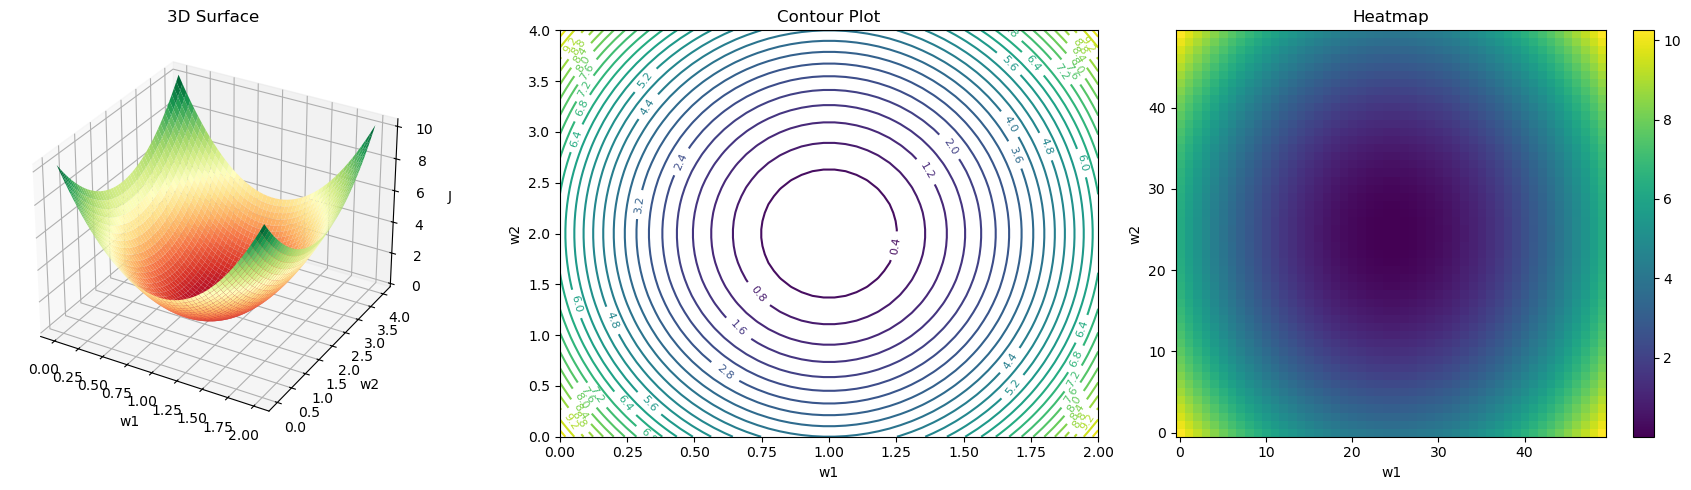

In [97]:
# 3D plot
w1 = np.linspace(0, 2, 50)
w2 = np.linspace(0, 4, 50)
w1, w2 = np.meshgrid(w1, w2)
J = 0.25 * ((5 - 5*w1)**2 + (4 - 2*w2)**2)
fig = plt.figure(figsize=(18, 5))

# -------------------------
# 1. 3D 曲面图
# -------------------------
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.plot_surface(w1, w2, J, cmap="RdYlGn")
ax1.set_title("3D Surface")
ax1.set_xlabel("w1")
ax1.set_ylabel("w2")
ax1.set_zlabel("J")

# -------------------------
# 2. 等高线图
# -------------------------
ax2 = fig.add_subplot(1, 3, 2)
contours = ax2.contour(w1, w2, J, levels=30)
ax2.clabel(contours, inline=True, fontsize=8)
ax2.set_title("Contour Plot")
ax2.set_xlabel("w1")
ax2.set_ylabel("w2")

# -------------------------
# 3. 热力图
# -------------------------
ax3 = fig.add_subplot(1, 3, 3)
im = ax3.imshow(J, origin='lower', aspect='auto')
plt.colorbar(im, ax=ax3)
ax3.set_title("Heatmap")
ax3.set_xlabel("w1")
ax3.set_ylabel("w2")

plt.tight_layout()
plt.show()


It is obvious to figure out that $w_{1}=1$ and $w_{2}=2$ can minimize $J$ to 0. However, when dealing with multiple examples and features, you cannot find the best solution through your eyes, but through fundamental math calculation: **gradient descent**. It is quite similar to **Newton's Method** in Calculus I, but some details are different. In general, it is an effective approach to minimize a multi-variable function.

### Gradient Descent
As seen in the graph, our goal is the "valley" point. Imagine J is a mountain, and we descent along the incline to reach the lowest point. Since the derivative of J is the slope of incline, we determin the descent direction through derivative. If it's bigger than 0, we head to the opposite direction to go down; if smaller than 0, then head to the same direction to go down. **In general, our direction is opposite to derivative.** 

Then how big the step we should take? That's the main difference between Gradient Descent and Newton's Method:
|Aspects|Gradient Descent|Newton's Method|
|:------|:---------------|:--------------|
|Formula|$W := W - \alpha \frac{\partial J}{\partial W}$|$W := W - [{\frac{\partial^{2} J}{\partial W^{2}}}]^{-1} \frac{\partial J}{\partial W}$|
|Meaning|Head to the lowest point with constant step length|Head to the lowest point with step length equals to curvature at that point|
|Geometric interpretation|Replace curved surface with plane|Replace curved surface with quadratic surface|
|Learning Rate|Fixed constant|Dynamic|
|Computational Cost|Small|Big|

### Visualize Gradient Descent
Still use the example before, now we implement gradient descent, to see how those parameters automatically head to the ideal result, where: 
$$n=2, m=2, b=0$$
$$W = \begin{bmatrix} w_{1} \\ w_{2} \end{bmatrix}$$
$$X = \begin{bmatrix} 5 & 0 \\ 0 & 2 \end{bmatrix}$$
$$Y = \begin{bmatrix} 5 & 4 \end{bmatrix}$$

In [8]:
# Record dots during descent
def visualize_linear_regression(start_point, learning_rate):
    dots = []
    w1, w2 = start_point
    iteration = 0
    while (abs(w1 - 1) >= 1e-9 or abs(w2-2) >= 2 * 1e-9) and iteration < 10000: 
        # simplified linear regression
        iteration += 1
        dots.append((w1, w2))
        J = 0.25 * ((5 - 5*w1)**2 + (4 - 2*w2)**2) 
        w1 -= learning_rate * 12.5 * (w1 - 1) # dJ/dw1
        w2 -= learning_rate * (2 * w2 - 4) # dJ/dw2
    return dots, iteration

# plot the figure, dots and arrow
def plot_gradient_descent(ax, start_point, learning_rate):
    w1 = np.linspace(-0.08, 2.08, 55)
    w2 = np.linspace(-0.16, 4.16, 55)
    w1, w2 = np.meshgrid(w1, w2)
    J = 0.25 * ((5 - 5*w1)**2 + (4 - 2*w2)**2)
    contours = ax.contour(w1, w2, J, levels=30)
    ax.clabel(contours, inline=True, fontsize=8)
    dots, iteration = visualize_linear_regression(start_point=start_point, learning_rate=learning_rate)
    ax.scatter([x for x, y in dots], [y for x, y in dots])
    for i in range(len(dots)-1):
        ax.arrow(dots[i][0], dots[i][1], dots[i+1][0]-dots[i][0], dots[i+1][1]-dots[i][1], head_width=0.05, head_length=0.1, fc='blue', ec='blue')
    ax.set_title(f"{start_point}, a={learning_rate}, #i={iteration}", fontsize=10)
    print(f"start point={start_point}, learning_rate={learning_rate}, #iteration={iteration})")
    ax.set(xticklabels=[], yticklabels=[])

def plot_all():
    learning_rate_list = [0.01, 0.02, 0.05, 0.1]
    start_point_list = [(0,0),(1,0),(2,3),(2,4)]
    fig, ax = plt.subplots(len(learning_rate_list), len(start_point_list), figsize=(16, 14))
    for i in range(len(learning_rate_list)):
        for j in range(len(start_point_list)):
            plot_gradient_descent(ax[i][j], start_point_list[j], learning_rate_list[i])
    fig.suptitle("Visualization of Gradient Descent", fontsize=24)
    fig.tight_layout()


start point=(0, 0), learning_rate=0.01, #iteration=1026)
start point=(1, 0), learning_rate=0.01, #iteration=1026)
start point=(2, 3), learning_rate=0.01, #iteration=992)
start point=(2, 4), learning_rate=0.01, #iteration=1026)
start point=(0, 0), learning_rate=0.02, #iteration=508)
start point=(1, 0), learning_rate=0.02, #iteration=508)
start point=(2, 3), learning_rate=0.02, #iteration=491)
start point=(2, 4), learning_rate=0.02, #iteration=508)
start point=(0, 0), learning_rate=0.05, #iteration=197)
start point=(1, 0), learning_rate=0.05, #iteration=197)
start point=(2, 3), learning_rate=0.05, #iteration=191)
start point=(2, 4), learning_rate=0.05, #iteration=197)
start point=(0, 0), learning_rate=0.1, #iteration=93)
start point=(1, 0), learning_rate=0.1, #iteration=93)
start point=(2, 3), learning_rate=0.1, #iteration=90)
start point=(2, 4), learning_rate=0.1, #iteration=93)


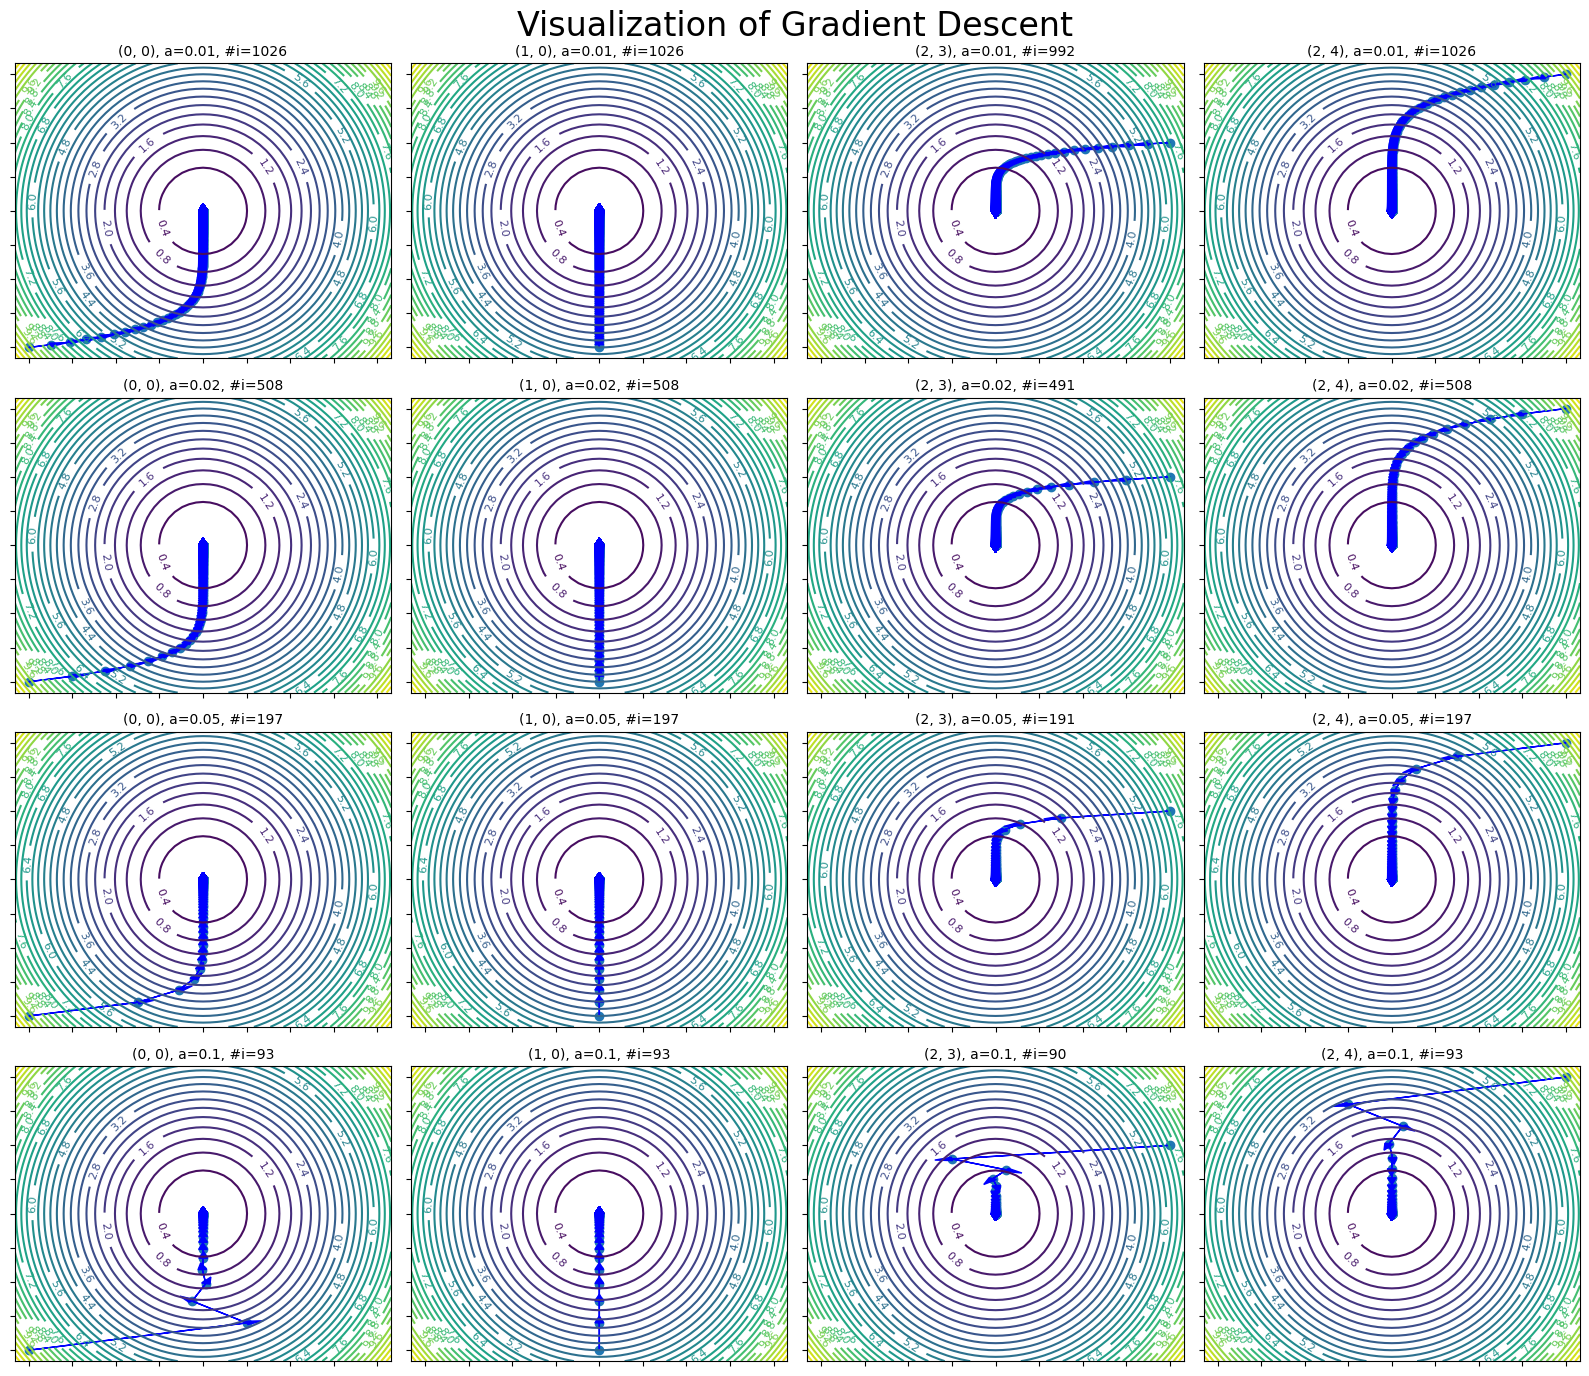

In [9]:
plot_all()

Expected output:

<img src="Visualize.png" width="50%">

The result is straight forward. All paths are heading to the lowest point. That is the main point of gradient descent. 

### Linear Regression - Back prop
The formal gradient descent, in linear regression, is the conclusions as follows:

First calculate dz, which is an essential pattern:
$$dz = \hat{Y} - Y$$
then calculate dw, db:
$$ dW = \frac{\partial J}{\partial W} = \frac{1}{m} X dz^{T} $$

$$ db = \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} dz_{i} $$
Inspired by that, I write down the following code.

In [10]:
def backprop(Y_predict, Y, W, X, b:float, learning_rate:float, lamda) -> np.array:
    m = X.shape[1] # number of examples
    dz = Y_predict - Y 
    dw = X @ dz.T / m
    db = np.sum(dz) / m
    W_modifyed = (1 - learning_rate*lamda / m)*W - learning_rate * dw
    b_modifyed = b - learning_rate * db
    return W_modifyed, b_modifyed

### Standardization, Normalization and Regularization
- Standardization transfer data to a distribution with mean=0 and variance=1:
$$Z = \frac{X-\mu}{\sigma} $$
- Normalization restrict data with a certain domain, usually [-1, 1]:
$$Z = \frac{X-\mu}{X_{max}-X_{min}} $$
- Regularization: penalty $\lambda$, which prevent model from overfitting
    - L1 Regularization: sum of absolute value of each weights in $W$
    - L2 Regularization: sum of square value of each weights in $W$

Of course, after trying, I found that the raw data should be restricted, and standardization performs much better than normalization, perhaps too many extremely high/low value disturb it. What's more, initial results shows a severe overfitting, so introducing L2 regularzation is also a must. 

In [51]:
# performance is much better.
def standardization(arr):
    row_avg = np.mean(arr, axis=1, keepdims=True)
    row_std = np.std(arr, axis=1, keepdims=True)
    arr_norm = (arr - row_avg) / (row_std + 1e-9)
    return arr_norm, row_avg, row_std

def linear_regression(X, Y, iterations, learning_rate, lamda):
    W, b = initialize(X)
    X_norm, X_avg, X_std = standardization(X)
    Y_norm, Y_avg, Y_std = standardization(Y)
    
    process = []
    for i in range(iterations):
        Y_predict = frontprop(W, X_norm, b)
        cost_val = cost(Y_predict, Y_norm, W, lamda)
        process.append((i+1, cost_val))
        if i%10 == 0:
            print(f"{i+1}th iteration, cost = {cost_val}")
        W, b = backprop(Y_predict, Y_norm, W, X_norm, b, learning_rate, lamda)
    cache = {"W":W, "b":b, "X_avg":X_avg, "X_std":X_std, "Y_avg":Y_avg, "Y_std":Y_std}
    return process, cache

In [52]:
# plot graph: cost vs. iterations
def train_data_plot(process):
    # plot the result of training set
    plt.plot([i for i,j in process], [j for i,j in process], label="Training Set")
    plt.xlabel("#Iterations")
    plt.ylabel("Cost")
    plt.legend()
    plt.grid(True)

In [53]:
# apply weights on dev/test
def predict(X, cache):
    W,b = cache["W"], cache["b"]
    X_avg, X_std, Y_avg, Y_std = cache["X_avg"], cache["X_std"], cache["Y_avg"], cache["Y_std"]
    X_norm = (X - X_avg) / (X_std + 1e-9)
    Y_predict = frontprop(W, X_norm, b)
    Y_predict = Y_predict * (Y_std + 1e-9) + Y_avg
    return Y_predict

In [80]:
# check
def COD(Y_true, Y_predict):
    return  1 - np.sum((Y_true - Y_predict)**2) / np.sum((Y_true - np.mean(Y_true))**2)

def RMSE(Y_true, Y_predict):
    return np.mean((Y_true - Y_predict)**2)**0.5


/var/folders/xc/qj85c6nj0vsdt0tbpkmxqhj00000gn/T/ipykernel_17907/2979583906.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cost_func = float((Y_predict - Y) @ (Y_predict - Y).T) / (2*m) + (lamda/(2*m))*(np.sum(np.square(W)))


1th iteration, cost = 0.499999999891836
11th iteration, cost = 0.4759288617463471
21th iteration, cost = 0.4541356927344676
31th iteration, cost = 0.4343865948287757
41th iteration, cost = 0.4164720833263904
51th iteration, cost = 0.4002045305136545
61th iteration, cost = 0.3854158771732821
71th iteration, cost = 0.3719555838671097
81th iteration, cost = 0.35968879686874905
91th iteration, cost = 0.34849470625339246
101th iteration, cost = 0.33826507600905653
111th iteration, cost = 0.3289029281435956
121th iteration, cost = 0.32032136465074007
131th iteration, cost = 0.3124425128893987
141th iteration, cost = 0.3051965814442454
151th iteration, cost = 0.2985210148907628
161th iteration, cost = 0.2923597371010553
171th iteration, cost = 0.2866624738127601
181th iteration, cost = 0.2813841461555964
191th iteration, cost = 0.2764843277004195
201th iteration, cost = 0.27192675837477753
211th iteration, cost = 0.2676789092864499
221th iteration, cost = 0.26371159312083464
231th iteration, 

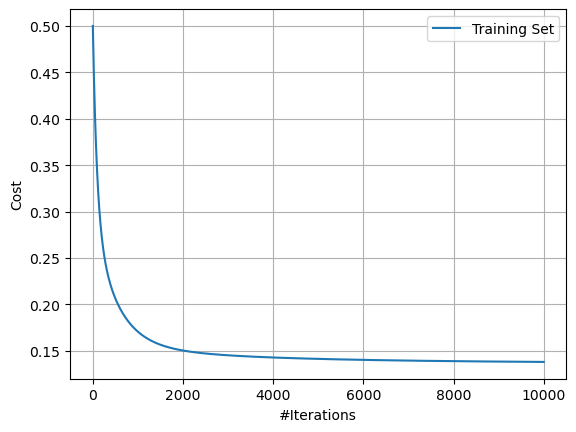

In [ ]:
# train the model
process, cache = linear_regression(
    X_train, Y_train, 
    iterations=10000, 
    learning_rate=0.001, 
    lamda=0)

train_data_plot(process)

In [ ]:
Y_train_predict = predict(X_train, cache)
Y_dev_predict = predict(X_dev, cache)
COD_train = COD(Y_train, Y_train_predict)
COD_dev = COD(Y_dev, Y_dev_predict)
RMSE_train = RMSE(Y_train, Y_train_predict)
RMSE_dev = RMSE(Y_dev, Y_dev_predict)
print(f"Coefficient of Determination: train = {COD_train}, dev = {COD_dev}")
print(f"Root Mean Square Error: train = {RMSE_train}, dev = {RMSE_dev}")

Coefficient of Determination: train = 0.723712807917311, dev = 0.7713457139095184
Root Mean Square Error: train = 4.85957731628004, dev = 4.538810552748643


In [114]:
Y_test_predict = predict(X_test, cache)
COD_test = COD(Y_test, Y_test_predict)
RMSE_test = RMSE(Y_test, Y_test_predict)
print(f"Coefficient of Determination: train = {COD_train}, dev = {COD_dev}, test = {COD_test}")
print(f"Root Mean Square Error: train = {RMSE_train}, dev = {RMSE_dev}, test = {RMSE_test}")

Coefficient of Determination: train = 0.723712807917311, dev = 0.7713457139095184, test = 0.5631121015643226
Root Mean Square Error: train = 4.85957731628004, dev = 4.538810552748643, test = 5.3327989757127


# 什么几把玩意，又他妈过拟合了，老子明天处理。等这个项目整完了，换一个数据集更大的试一试

# AI又给了一堆东西，容我慢慢消化学习。可能概率论是时候捡起来一部分了，这个弄完看一看sklearn, pytorch里面分别是如何进行的。全搞清楚之后回来迭代代码，最后再去复习逻辑回归，二分类去